In [1]:
"""
Purpose: Implement Placeholders algorithm from "Learning Placeholders for Open-Set Recognition"
    and compare its performance to simple confidence thresholding on a logistic regression classifier.

Following https://builtin.com/data-science/guide-logistic-regression-tensorflow-20
"""

'\nPurpose: Implement Placeholders algorithm from "Learning Placeholders for Open-Set Recognition"\n    and compare its performance to simple confidence thresholding on a logistic regression classifier.\n\nFollowing https://builtin.com/data-science/guide-logistic-regression-tensorflow-20\n'

In [2]:
import numpy as np
from mnist import MNIST
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tqdm import tqdm

In [3]:
NUM_CLASSES = 10
NUM_FEATURES = 784

def load_dataset():
    mndata = MNIST('/Users/jmmar/Google Drive/School/ASU/Fall 2022/EEE 598/HW2/data/')
    mndata.gz = True  # allows the use of the .gz compressed files
    tensor = lambda data: tf.convert_to_tensor(data, dtype=tf.float32)
    X_train, y_train = map(tensor, mndata.load_training())
    X_test, y_test = map(tensor, mndata.load_testing())
    X_train = X_train/255.0
    X_test = X_test/255.0
    return X_train, y_train, X_test, y_test

def validation_split(X, y, val_size=.2):
    """Input are expected to be tensors.
    """
    tensor = lambda data: tf.convert_to_tensor(data, dtype=tf.float32)
    X_train, X_val, y_train, y_val = map(tensor, train_test_split(X.numpy(), y.numpy()))
    return X_train, X_val, y_train, y_val

In [4]:
X, y, X_test, y_test = load_dataset()

In [5]:
def plot_loss(train_losses, val_losses):
    iterations = list(range(len(train_losses)))
    plt.plot(iterations, train_losses, label='Train')
    plt.plot(iterations, val_losses, label='Validation')
    plt.xlabel('Iterations')
    plt.ylabel('Cross Entropy Loss')
    plt.legend()
    plt.title('Loss While Training')
    plt.show()
    
def plot_acc(train_accs, val_accs):
    iterations = list(range(len(train_accs)))
    plt.plot(iterations, train_accs, label='Train')
    plt.plot(iterations, val_accs, label='Validation')
    plt.xlabel('Iterations')
    plt.ylabel('Classification Accuracy')
    plt.legend()
    plt.title('Accuracy While Training')
    plt.show()

In [6]:
class StandardLogisticRegressionModel(tf.keras.Model):
    def __init__(self, pre_dim, post_dim, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.embed_pre = tf.keras.layers.Dense(pre_dim, activation='sigmoid', name='embed_pre')
        self.embed_post = tf.keras.layers.Dense(post_dim, activation='sigmoid', name='embed_post')
        self.logits_layer = tf.keras.layers.Dense(num_classes, activation=None, name='ligits')
        self.output_layer = tf.keras.layers.Softmax(name='output')
        
    def call(self, inputs):
        x_pre = self.embed_pre(inputs)
        x_post = self.embed_post(x_pre)
        logits = self.logits_layer(x_post)
        return self.output_layer(logits)

def ce_loss(y_true, y_pred):
    """ Cross Entropy Loss.
    y_true: one-hot encoded class labels
    y_pred: class probabilities
    """
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

def accuracy(y_true, y_pred):
    """y_true is the true class labels (not one-hot encoded) and y_pred are the predicted
    class labels (not class probabilities).
    """
    correct_preds = tf.equal(tf.cast(y_true, tf.int64), y_pred)
    return tf.reduce_mean(tf.cast(correct_preds, tf.float32))

In [7]:
pre_dim = post_dim = 50
model = StandardLogisticRegressionModel(
    pre_dim=pre_dim, 
    post_dim=post_dim, 
    num_classes=NUM_CLASSES
)
model.compile(
    optimizer='adam', 
    loss=ce_loss, 
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc')]
)
y_train_one_hot = tf.one_hot(tf.cast(y, tf.int64), depth=model.num_classes)
history = model.fit(X, y_train_one_hot, epochs=10, validation_split=.2)

Epoch 1/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.6848 - acc: 0.8392 - val_loss: 0.2856 - val_acc: 0.9195
Epoch 2/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2508 - acc: 0.9284 - val_loss: 0.2061 - val_acc: 0.9412
Epoch 3/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1867 - acc: 0.9454 - val_loss: 0.1707 - val_acc: 0.9508
Epoch 4/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1496 - acc: 0.9561 - val_loss: 0.1487 - val_acc: 0.9572
Epoch 5/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1244 - acc: 0.9635 - val_loss: 0.1318 - val_acc: 0.9622
Epoch 6/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.1056 - acc: 0.9693 - val_loss: 0.1316 - val_acc: 0.9617
Epoch 7/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0914 - acc: 0.9731 - val_loss: 0.1196 - val_acc: 0.9646
Epoch 8/10
1500/1500 [==============================] - 2s 1ms

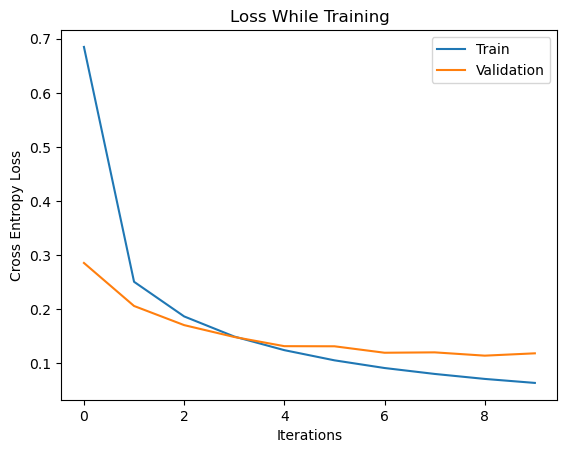

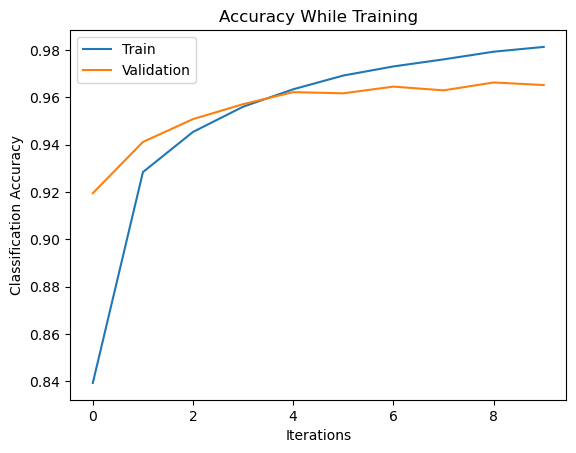

In [8]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plot_loss(train_loss, val_loss)

train_acc = history.history['acc']
val_acc = history.history['val_acc']
plot_acc(train_acc, val_acc)

In [9]:
""" 
Now we attempt open-set classicfication by training a logistic regression model on k 
classes (digits 0-8 for this dataset) and test on k+1. If all predicted class probabilities
are below a threshold, predict the open set.
"""
    
def threshold_predict(X, model, threshold):
    y_pred = model.call(X)
    highest_prob = tf.reduce_max(y_pred, axis=1)
    return tf.where(highest_prob < threshold, -1, tf.argmax(y_pred, axis=1))

def remove_classes_from_dataset(X, y, class_labels):
    """Removes samples from both X and y that correspond to classes given in class_labels
    class_labels: list of class_labels e.g. [3,4,9]
    y: tensor containing class labels (not yet one-hot encoded)
    """
    to_remove_mask = tf.reduce_all([y != label for label in class_labels], axis=0)
    y = tf.boolean_mask(y, to_remove_mask)
    X = tf.boolean_mask(X, to_remove_mask)
    return X, y

def modify_open_set_labels(y, open_set_class_labels):
    """Replaces class labels from the open set in y with -1
    """
    open_set_idx = tf.reduce_any([y == label for label in open_set_class_labels], axis=0)
    return tf.where(open_set_idx, -1, y)

def open_set_accuracy(y_true, y_pred):
    """ fraction of samples in the open set that are classified correctly.
    """
    y_true = tf.cast(y_true, tf.int64)
    open_set_idx = y_true == -1
    return accuracy(y_true[open_set_idx], y_pred[open_set_idx])

def closed_set_accuracy(y_true, y_pred):
    """ fraction of samples in the open set that are classified correctly.
    """
    y_true = tf.cast(y_true, tf.int64)
    closed_set_idx = y_true != -1
    return accuracy(y_true[closed_set_idx], y_pred[closed_set_idx])
    #return tf.reduce_sum(tf.equal(y_true[closed_set_idx], y_pred[closed_set_idx]))

def plot_open_closed_accuracy(all_acc, open_acc, closed_acc):
    plt.plot(threshold_value, all_acc, label='All class accuracy')
    plt.plot(threshold_value, open_acc, label='Open set accuracy')
    plt.plot(threshold_value, closed_acc, label='Closed set accuracy')
    plt.xlabel('Classification Probability Threshold')
    plt.ylabel('Classification Accuracy')
    plt.legend()
    plt.title('Effect of Threshold on Accuracy')
    plt.show()

Epoch 1/15
1014/1014 [==============================] - 2s 1ms/step - loss: 0.7518 - acc: 0.8312 - val_loss: 0.2881 - val_acc: 0.9236
Epoch 2/15
1014/1014 [==============================] - 1s 1ms/step - loss: 0.2486 - acc: 0.9298 - val_loss: 0.2042 - val_acc: 0.9403
Epoch 3/15
1014/1014 [==============================] - 1s 1ms/step - loss: 0.1881 - acc: 0.9462 - val_loss: 0.1678 - val_acc: 0.9492
Epoch 4/15
1014/1014 [==============================] - 1s 1ms/step - loss: 0.1551 - acc: 0.9557 - val_loss: 0.1534 - val_acc: 0.9528
Epoch 5/15
1014/1014 [==============================] - 1s 1ms/step - loss: 0.1306 - acc: 0.9634 - val_loss: 0.1376 - val_acc: 0.9577
Epoch 6/15
1014/1014 [==============================] - 1s 1ms/step - loss: 0.1118 - acc: 0.9687 - val_loss: 0.1263 - val_acc: 0.9625
Epoch 7/15
1014/1014 [==============================] - 1s 1ms/step - loss: 0.0971 - acc: 0.9728 - val_loss: 0.1241 - val_acc: 0.9605
Epoch 8/15
1014/1014 [==============================] - 1s 1ms

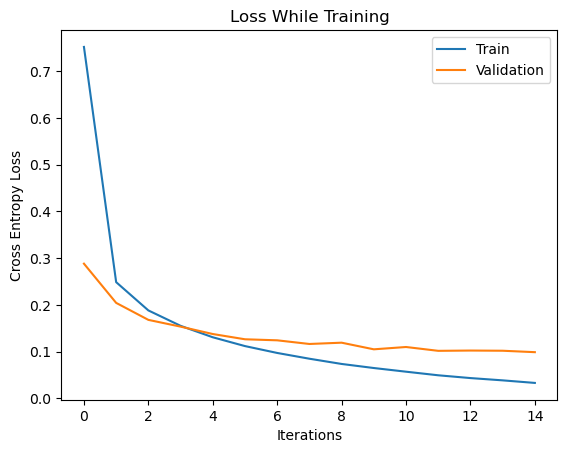

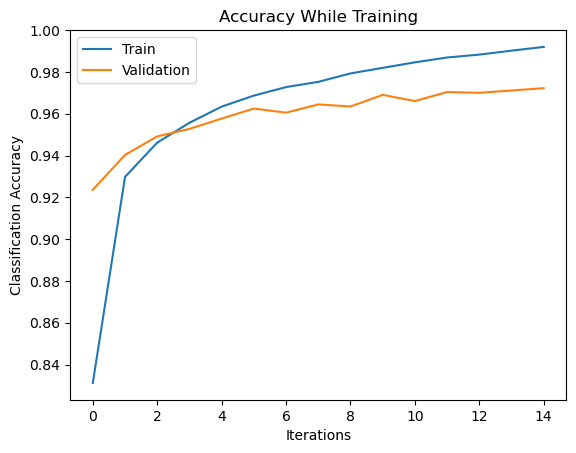

In [10]:
# train for closed set classification on 0-8, 9 is removed before training
# from the train set, but is left in the valdation set
open_set_class_labels = [9] 

X_train, X_val, y_train, y_val = validation_split(X, y)
X_train_closed, y_train_closed = remove_classes_from_dataset(X_train, y_train, open_set_class_labels)

# convert instances of class labels in the open set to -1
y_val_open = modify_open_set_labels(y_val, open_set_class_labels)

pre_dim = post_dim = 50
model = StandardLogisticRegressionModel(pre_dim, post_dim, NUM_CLASSES - 1)
model.compile(optimizer='adam', loss=ce_loss, metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc')])
y_train_one_hot = tf.one_hot(tf.cast(y_train_closed, tf.int64), depth=model.num_classes)
history = model.fit(X_train_closed, y_train_one_hot, epochs=15, validation_split=.2)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
plot_loss(train_loss, val_loss)

train_acc = history.history['acc']
val_acc = history.history['val_acc']
plot_acc(train_acc, val_acc)

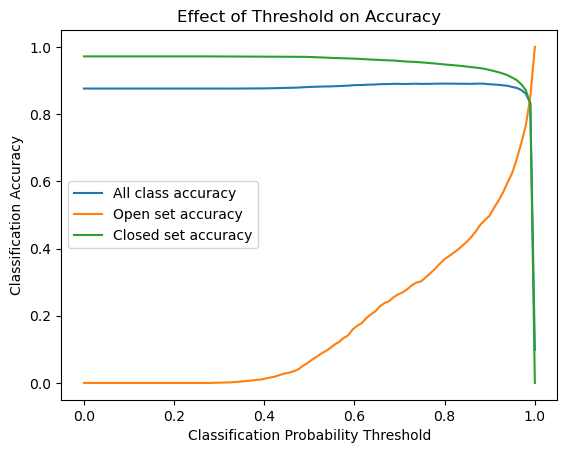

total accuracy:      0.8909
open-set accuracy:   0.3665
closed-set accuracy: 0.9481
optimal threshold:   0.7980


In [11]:
# See how the threshold value affects open-set accuracy
threshold_value = np.linspace(0, 1, 100)

total_acc = []
open_set_acc = []
closed_set_acc = []

max_total_acc = 0
best_threshold = 0

for threshold in threshold_value:
    y_pred = threshold_predict(X_val, model, threshold)
    total_acc.append(accuracy(y_val_open, y_pred))
    open_set_acc.append(open_set_accuracy(y_val_open, y_pred))
    closed_set_acc.append(closed_set_accuracy(y_val_open, y_pred))
    
plot_open_closed_accuracy(total_acc, open_set_acc, closed_set_acc)

best_total_acc_idx = np.argmax(total_acc)
print('total accuracy:      {:.4f}'.format(float(total_acc[best_total_acc_idx])))
print('open-set accuracy:   {:.4f}'.format(float(open_set_acc[best_total_acc_idx])))
print('closed-set accuracy: {:.4f}'.format(float(closed_set_acc[best_total_acc_idx])))
print('optimal threshold:   {:.4f}'.format(float(threshold_value[best_total_acc_idx])))

In [12]:
""" Now that we have a baseline, we will implement the placeholders algorithm.
"""

class OpenSetPlaceholdersLRM(StandardLogisticRegressionModel):
    def __init__(self, num_placeholders, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_placeholders = num_placeholders
        self.dummy_logits_layer = tf.keras.layers.Dense(num_placeholders, activation=None, name='dummy_logits')

    def call(self, inputs):
        x_pre = self.embed_pre(inputs)
        x_post = self.embed_post(x_pre)
        closed_set_logits = self.logits_layer(x_post)
        dummy_logits = self.dummy_logits_layer(x_post)
        max_dummy_logit = tf.reduce_max(dummy_logits, axis=1)
        all_logits = tf.concat([closed_set_logits, tf.expand_dims(max_dummy_logit, 1)], axis=1)
        return self.output_layer(all_logits)
        
    def predict(self, x):
        """ Returns the predicted class label. If predicted class is dummy class, return -1
        indicating prediction falls within the open set.
        """
        y_pred = self.__call__(x)
        y_pred_labels = tf.argmax(y_pred, axis=1)
        return tf.where(y_pred_labels == self.num_classes, -1, y_pred_labels)
    
def ce_loss_for_placeholders(y_true, y_pred, beta):
    loss = ce_loss(y_true, y_pred)
    # set each sample's predicted probability for the true class to zero
    y_pred_without_true_prob = tf.where(y_true == 1, 0., y_pred)
    # create a new y_true where the true label is the dummy class
    rows, cols = y_true.shape
    rows = rows or 1
    y_true_dummy = tf.concat([tf.zeros([rows, cols - 1]), tf.ones([rows, 1])], axis=1)
    loss += beta * ce_loss(y_true_dummy, y_pred_without_true_prob)
    return loss

Epoch 1/20
1013/1013 [==============================] - 2s 2ms/step - loss: 1.9616 - acc: 0.4160 - val_loss: 1.5540 - val_acc: 0.6753
Epoch 2/20
1013/1013 [==============================] - 1s 1ms/step - loss: 1.4928 - acc: 0.7019 - val_loss: 1.4553 - val_acc: 0.7325
Epoch 3/20
1013/1013 [==============================] - 1s 1ms/step - loss: 1.4217 - acc: 0.7646 - val_loss: 1.4117 - val_acc: 0.8058
Epoch 4/20
1013/1013 [==============================] - 1s 1ms/step - loss: 1.3812 - acc: 0.8019 - val_loss: 1.3812 - val_acc: 0.8085
Epoch 5/20
1013/1013 [==============================] - 1s 1ms/step - loss: 1.3533 - acc: 0.8263 - val_loss: 1.3663 - val_acc: 0.8112
Epoch 6/20
1013/1013 [==============================] - 1s 1ms/step - loss: 1.3334 - acc: 0.8396 - val_loss: 1.3527 - val_acc: 0.8358
Epoch 7/20
1013/1013 [==============================] - 1s 1ms/step - loss: 1.3170 - acc: 0.8505 - val_loss: 1.3444 - val_acc: 0.8395
Epoch 8/20
1013/1013 [==============================] - 1s 1ms

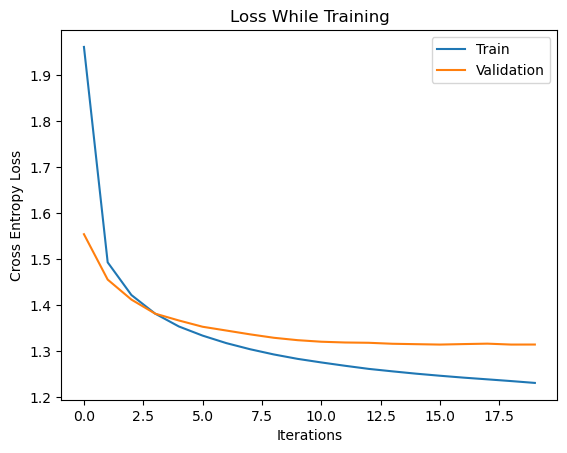

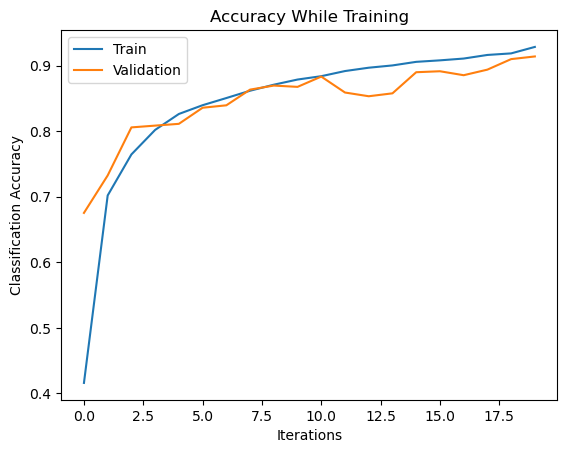

In [13]:
# train for closed set classification on 0-8, 9 is removed before training
# from the train set, but is left in the valdation set
open_set_class_labels = [9] 

X_train, X_val, y_train, y_val = validation_split(X, y)
X_train_closed, y_train_closed = remove_classes_from_dataset(X_train, y_train, open_set_class_labels)

# convert instances of class labels in the open set to -1
y_val_open = modify_open_set_labels(y_val, open_set_class_labels)

num_placeholders = 20
pre_dim = post_dim = 50
model = OpenSetPlaceholdersLRM(
    pre_dim=pre_dim, 
    post_dim=post_dim, 
    num_classes=NUM_CLASSES - 1,
    num_placeholders=num_placeholders
)
beta = .75
loss = lambda *x: ce_loss_for_placeholders(*x, beta)
model.compile(
    optimizer='adam', 
    loss=loss, 
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc')]
)
# The "+ 1"s below add an additional column of zeros to the one-hot encodings for
# the dummy class
y_train_one_hot = tf.one_hot(tf.cast(y_train_closed, tf.int64), depth=model.num_classes + 1)
history = model.fit(X_train_closed, y_train_one_hot, epochs=20, validation_split=.2, batch_size=32)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
plot_loss(train_loss, val_loss)

train_acc = history.history['acc']
val_acc = history.history['val_acc']
plot_acc(train_acc, val_acc)

In [14]:
total_acc = []
open_set_acc = []
closed_set_acc = []

y_pred = model.predict(X_val)

print('total accuracy:      {:.4f}'.format(accuracy(y_val_open, y_pred)))
print('open-set accuracy:   {:.4f}'.format(open_set_accuracy(y_val_open, y_pred)))
print('closed-set accuracy: {:.4f}'.format(closed_set_accuracy(y_val_open, y_pred)))

total accuracy:      0.8858
open-set accuracy:   0.6671
closed-set accuracy: 0.9095


In [15]:
### THE CODE BELOW IS A WORK IN PROGRESS AND DOES NOT CURRENTLY RUN ###


"""We will now introduce data placeholders. In essence, we will be synthesizing open-set training
data via a process called "manifold mixup". We will also introduce a new loss function which makes
use of the new synthetic data.
"""

# Open set placeholder
class OSPWithDataPlaceholdersLRM(OpenSetPlaceholdersLRM):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def train_step(self, data):
        """ Inspired by https://keras.io/guides/customizing_what_happens_in_fit/
        """
        x, y = data
        
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
            
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

1013/1013 [==============================] - 2s 2ms/step - loss: 1.9581 - acc: 0.4157 - val_loss: 1.5572 - val_acc: 0.6674


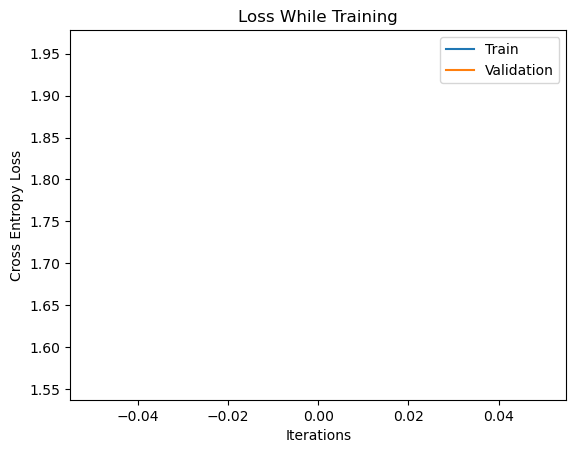

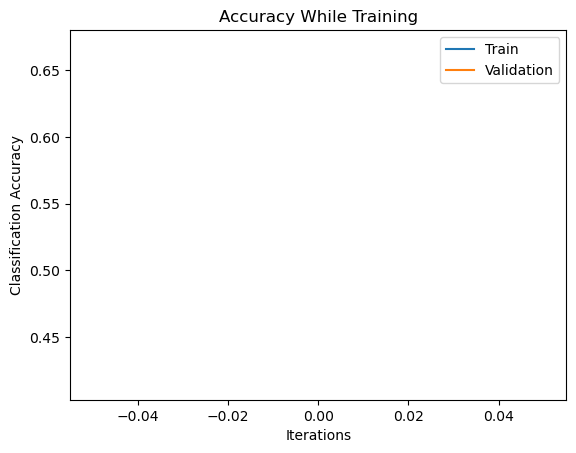

In [16]:
"""

# train for closed set classification on 0-8, 9 is removed before training
# from the train set, but is left in the valdation set
open_set_class_labels = [9] 

X_train, X_val, y_train, y_val = validation_split(X, y)
X_train_closed, y_train_closed = remove_classes_from_dataset(X_train, y_train, open_set_class_labels)

# convert instances of class labels in the open set to -1
y_val_open = modify_open_set_labels(y_val, open_set_class_labels)

num_placeholders = 20
pre_dim = post_dim = 50
model = OSPWithDataPlaceholdersLRM(
    pre_dim=pre_dim, 
    post_dim=post_dim, 
    num_classes=NUM_CLASSES - 1,
    num_placeholders=num_placeholders
)
beta = .75
loss = lambda *x: ce_loss_for_placeholders(*x, beta)
model.compile(
    optimizer='adam', 
    loss=loss, 
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc')]
)
# The "+ 1"s below add an additional column of zeros to the one-hot encodings for
# the dummy class
y_train_one_hot = tf.one_hot(tf.cast(y_train_closed, tf.int64), depth=model.num_classes + 1)
history = model.fit(X_train_closed, y_train_one_hot, epochs=1, validation_split=.2, batch_size=32)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
plot_loss(train_loss, val_loss)

train_acc = history.history['acc']
val_acc = history.history['val_acc']
plot_acc(train_acc, val_acc)

"""